# Predict Customer Clicked Ads Classification by Using Machine Learning

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from category_encoders import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, PowerTransformer, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

from matplotlib import pyplot as plt
from matplotlib import rcParams

pd.options.display.max_columns = None

custom_rc = {'figure.figsize': (12,8),
             'axes.labelsize': 14,
             'figure.titlesize': 18}
rcParams.update(custom_rc)

In [2]:
plt.style.use('ggplot')

## About This Dataset
[This dataset](https://drive.google.com/file/d/1WwLxmK8PMLjjgG_Zh1Nkh02ZN2-3Wiyl/view) distributed by Rakamin Academy appears to be a modified version of [Click on Ad Dataset](https://www.kaggle.com/datasets/gabrielsantello/advertisement-click-on-ad) on Kaggle. From a quick Google search, the oldest recorded version of this data on Kaggle can be found [here](https://www.kaggle.com/code/farhanmd29/predicting-customer-ad-clicks/notebook) stating that it's from a private dataset. There is no information found about how this dataset was acquired.

Ads performance is important to achieve a successful marketing. In this case, I take the role of a data scientist working for a company in Indonesia. This company wants to evaluate their ads effectiveness using their historical advertisement data. The objective of this case will be to help the company to determine the marketing target using classification algorithm machine learning.

In [3]:
filepath = "Clicked Ads Dataset.csv"
df_raw = pd.read_csv(filepath, index_col=0)
df = df_raw.copy()
df.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Male,Timestamp,Clicked on Ad,city,province,category
0,68.95,35,432837300.0,256.09,Perempuan,3/27/2016 0:53,No,Jakarta Timur,Daerah Khusus Ibukota Jakarta,Furniture
1,80.23,31,479092950.0,193.77,Laki-Laki,4/4/2016 1:39,No,Denpasar,Bali,Food
2,69.47,26,418501580.0,236.50,Perempuan,3/13/2016 20:35,No,Surabaya,Jawa Timur,Electronic
3,74.15,29,383643260.0,245.89,Laki-Laki,1/10/2016 2:31,No,Batam,Kepulauan Riau,House
4,68.37,35,517229930.0,225.58,Perempuan,6/3/2016 3:36,No,Medan,Sumatra Utara,Finance


## Data Overview

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Daily Time Spent on Site  987 non-null    float64
 1   Age                       1000 non-null   int64  
 2   Area Income               987 non-null    float64
 3   Daily Internet Usage      989 non-null    float64
 4   Male                      997 non-null    object 
 5   Timestamp                 1000 non-null   object 
 6   Clicked on Ad             1000 non-null   object 
 7   city                      1000 non-null   object 
 8   province                  1000 non-null   object 
 9   category                  1000 non-null   object 
dtypes: float64(3), int64(1), object(6)
memory usage: 85.9+ KB


The columns are easy to understand and self-explanatory. Here are the columns' descriptions in consideration to their values:
- **Daily Time Spent on Site**: daily time spent by customers on the site in minutes
- **Age**: customers' ages in years
- **Area Income**: customers' average income based on neighborhood area, possibly in Rupiah
- **Daily Internet Usage**: daily time spent by customers on the internet in minutes
- **Male**: customers' gender
- **Timestamp**: timestamps for action taken by customers on seeing ad
- **Clicked on Ad**: actions taken by customers on seeing ad, 'Yes' if customers click on ad and 'No' if customers click away to leave webpage without clicking on ad
- **city**: customers' cities
- **province**: customers' province
- **category**: categories of ads seen by customers

From quick overview based on the columns' values, **Male** column should have values of 'Yes' or 'No' or binary numbers instead of gender values 'Perempuan' or 'Laki-Laki'.

There are some missing values in some columns found.

Since the end objective is to make a classification model to find target customers who will click on ads, the target feature will be **Clicked on Ad**

In [5]:
# Rename columns for accessibility
col_rename = {'Daily Time Spent on Site': 'DailyTimeOnSite',
              'Area Income': 'AreaIncome',
              'Daily Internet Usage': 'DailyNetUsage',
              'Clicked on Ad': 'AdClick'}
df.rename(columns=col_rename, inplace=True)

## Customer Type and Behaviour Analysis on Advertisement
Before going to data preparation, let's try to understand the problem at hand first. It's important to see the customer base of the company to see their behaviour towards the company's ads previously.

### Descriptive Analysis
Let's take a look on customers' distribution in this dataset for every available features.

In [6]:
# Separate categorical and numerical columns
cats = df.select_dtypes(include='object').columns
nums = df.drop(cats, axis=1).columns

#### Categorical Features

In [7]:
df[cats].describe().T

,count,unique,top,freq
Male,997,2,Perempuan,518
Timestamp,1000,997,5/26/2016 15:40,2
AdClick,1000,2,No,500
city,1000,30,Surabaya,64
province,1000,16,Daerah Khusus Ibukota Jakarta,253
category,1000,10,Otomotif,112


Some observations to make from the table:
- **Male** column has some missing values
- **Male** column is a binary feature with close to perfect 50:50 split in values
- **AdClick** column is a binary feature with perfect 50:50 split in values
- **Province** column is dominated by 'Daerah Khusus Ibukota Jakarta' with over 25% distribution
- **Timestamp** is a datetime column

**City** and **province** have many unique values, so it might be hard to visualize them. Let's take a look of **category** distribution to get an idea of the dataset.

In [8]:
df.category.value_counts(normalize=True)

Otomotif      0.112
House         0.109
Health        0.104
Fashion       0.102
Food          0.099
Furniture     0.098
Travel        0.098
Electronic    0.097
Finance       0.091
Bank          0.090
Name: category, dtype: float64

It appears that **category** column has pretty much even distribution between all 10 category at distribution range of 9-11% per category. 

#### Numerical Features

In [9]:
df[nums].describe().T

,count,mean,std,min,25%,50%,75%,max
DailyTimeOnSite,987.0,6.492952e+01,1.584470e+01,32.60,5.127000e+01,6.811000e+01,7.846000e+01,9.143000e+01
Age,1000.0,3.600900e+01,8.785562e+00,19.00,2.900000e+01,3.500000e+01,4.200000e+01,6.100000e+01
AreaIncome,987.0,3.848647e+08,9.407999e+07,97975500.00,3.286330e+08,3.990683e+08,4.583554e+08,5.563936e+08
DailyNetUsage,989.0,1.798636e+02,4.387014e+01,104.78,1.387100e+02,1.826500e+02,2.187900e+02,2.670100e+02


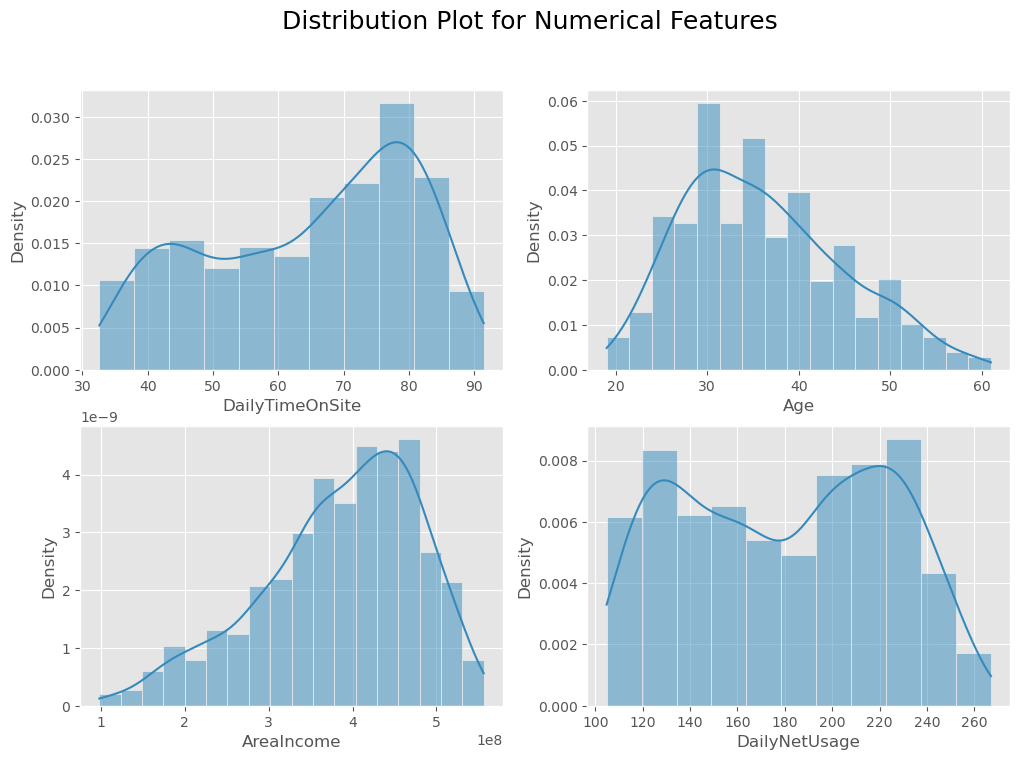

In [10]:
plt.suptitle('Distribution Plot for Numerical Features')
for i, col in enumerate(nums):
    plt.subplot(2, 2, i+1)
    sns.histplot(x=df[col], kde=True, stat='density')
plt.show()

Some observation to make:
- **Age** and **AreaIncome** seem to be normal distribution based on how close the mean and median are. Both distributions seem to be pretty close to normal distribution with a slight skew.
- **DailyTimeOnSite** and **DailyNetUsage** have bimodal distributions, we might need to use a different approach to analyze

### Univariate Analysis
For this section, I will be focusing on the impact of 3 features towards customers' decision to click on ads. The features are **Age**, **DailyTimeOnSite**, and **DailyNetUsage**

#### Age

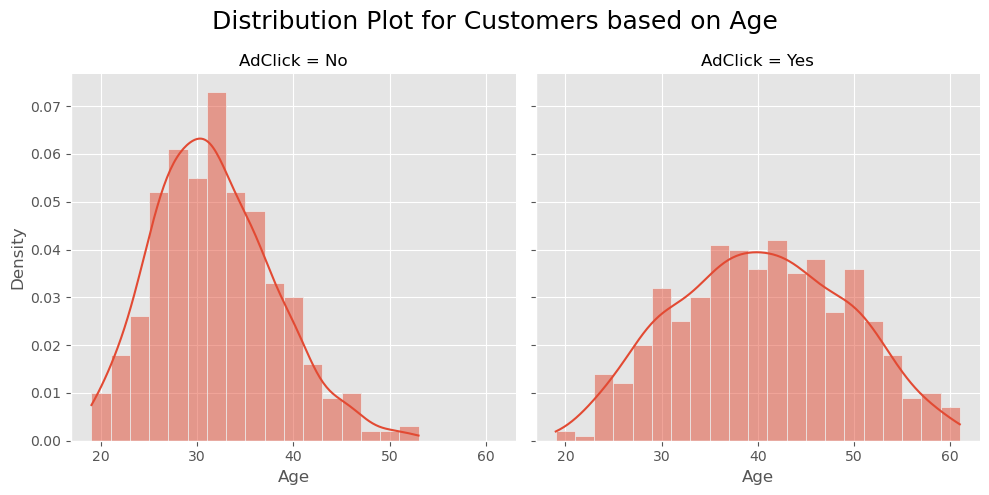

In [11]:
g = sns.FacetGrid(df, col='AdClick', height=5)
plt.suptitle('Distribution Plot for Customers based on Age')
g.map(sns.histplot, 'Age', stat='density', kde=True, binwidth=2)
plt.show()

Based on the graph above, the customers who clicked on ad are somewhere within the age range of 19-61 years old. However, for customers who didn't click on ad, the age range seems to be in the range of 19-53. 

Based on their distributions, both graph show normal distribution. However, for customers who didn't click on ad, the distribution is the highest in age range of 25-35 years old. That can possibly mean that the previous ads failed to attract customers in that age range.

#### Daily Time Spent on Site

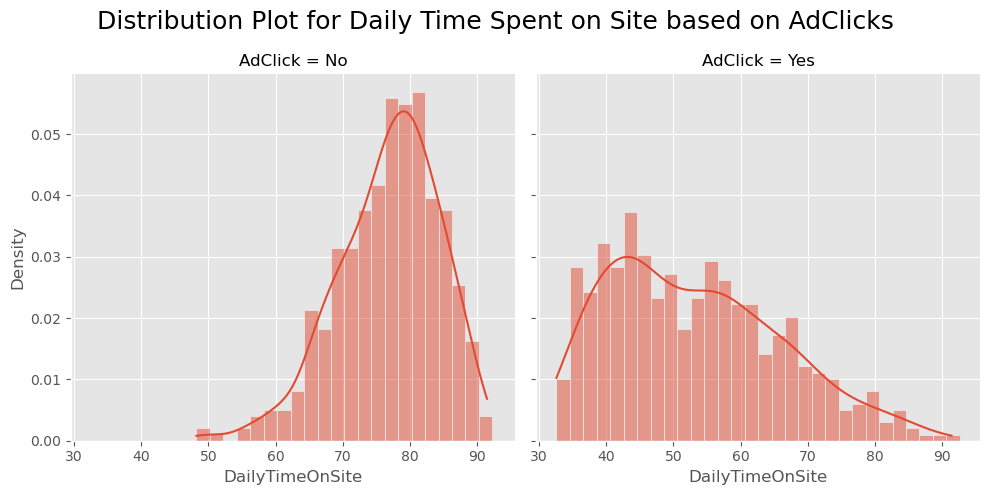

In [12]:
g = sns.FacetGrid(df, col='AdClick', height=5)
plt.suptitle('Distribution Plot for Daily Time Spent on Site based on AdClicks')
g.map(sns.histplot, 'DailyTimeOnSite', stat='density', kde=True, binwidth=2)
plt.show()

Based on graph above, customers who didn't click on ad are mostly distributed on the higher end of daily time spent on site in range between 68-88 minutes. Meanwhile, for customers who clicked on ad, the distribution is more spreadout with the majority spent between 34-68 minutes daily on site.

#### Daily Internet Usage

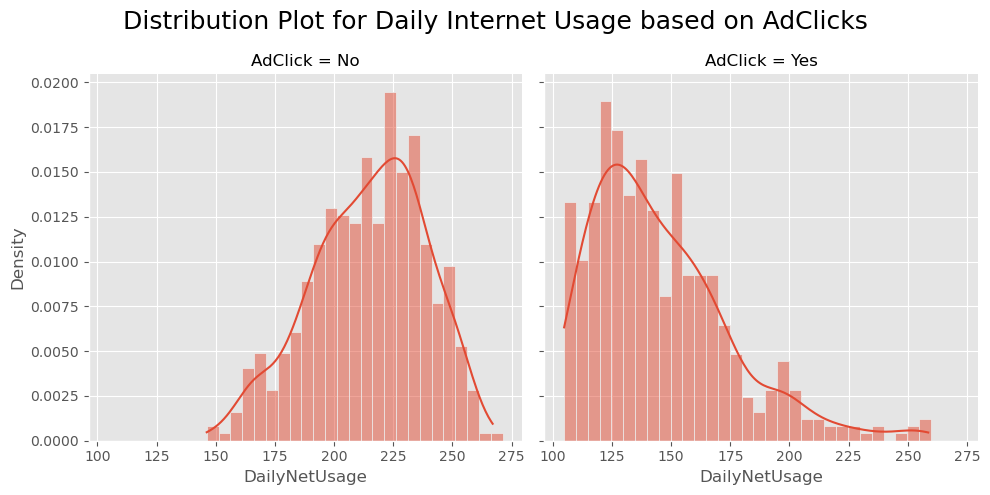

In [13]:
g = sns.FacetGrid(df, col='AdClick', height=5)
plt.suptitle('Distribution Plot for Daily Internet Usage based on AdClicks')
g.map(sns.histplot, 'DailyNetUsage', stat='density', kde=True, binwidth=5)
plt.show()

Based on graph above, customers who didn't click on ad are mostly distributed on the higher end of the duration, just like with daily time spent. For daily internet usage, most of the customers who didn't click are distributed in the range of 185-250 minutes daily, while most of customers who click are distributed in the range of 105-170 minutes daily.

Based on daily time spent and daily internet usage, it appears that customers who generally spends less time online are the one more interested to click on ad. These are possibly tied to the age demographic where the younger customers age range is the more they spend time on site and online. In this case, one hypothesis that I take will be that the previous ads weren't interesting enough for younger customerbase below 40 years old. That can be a problem since there is quite a big distribution of customerbase there. 

### Bivariate Analysis

#### Impact of 3 Requested Features towards AdClick
Let's take another look on the previous 3 features using boxplot.

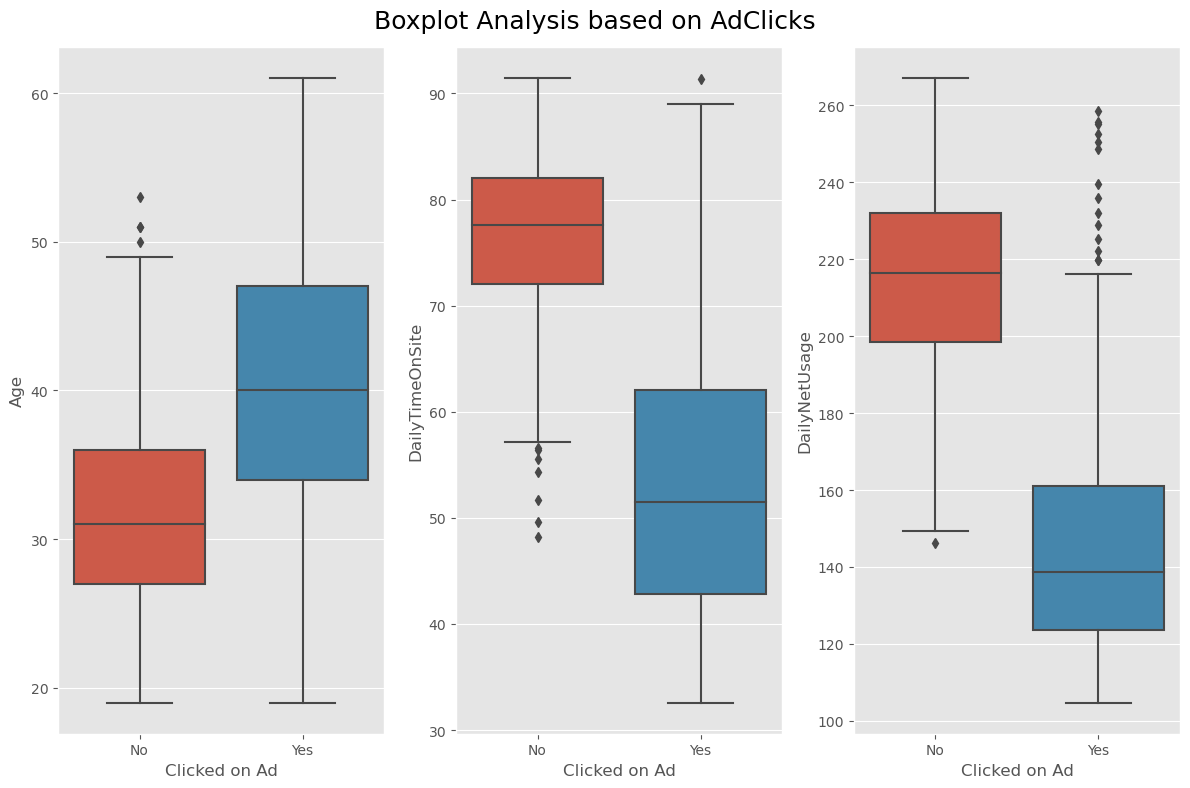

In [14]:
req_features = ['Age', 'DailyTimeOnSite', 'DailyNetUsage']
plt.suptitle('Boxplot Analysis based on AdClicks')
for i, col in enumerate(req_features):
    plt.subplot(1, 3, i+1)
    sns.boxplot(y=df[col], x=df.AdClick)
    plt.xlabel('Clicked on Ad')
plt.tight_layout()
plt.show()

From the graph above, we can see that for customers who clicked on add based on age, it is in fact normal distribution. For customers who didn't click on add based on age, there are small amount of outlier found, so do distributions in the other 2 features.

From the graph, we can also observe that for daily time spent on site and daily internet usage have similar distribution pattern as expected. It might be a good idea to take a closer look using multivariate analysis to see how they correlate with each others.

### Multivariate Analysis

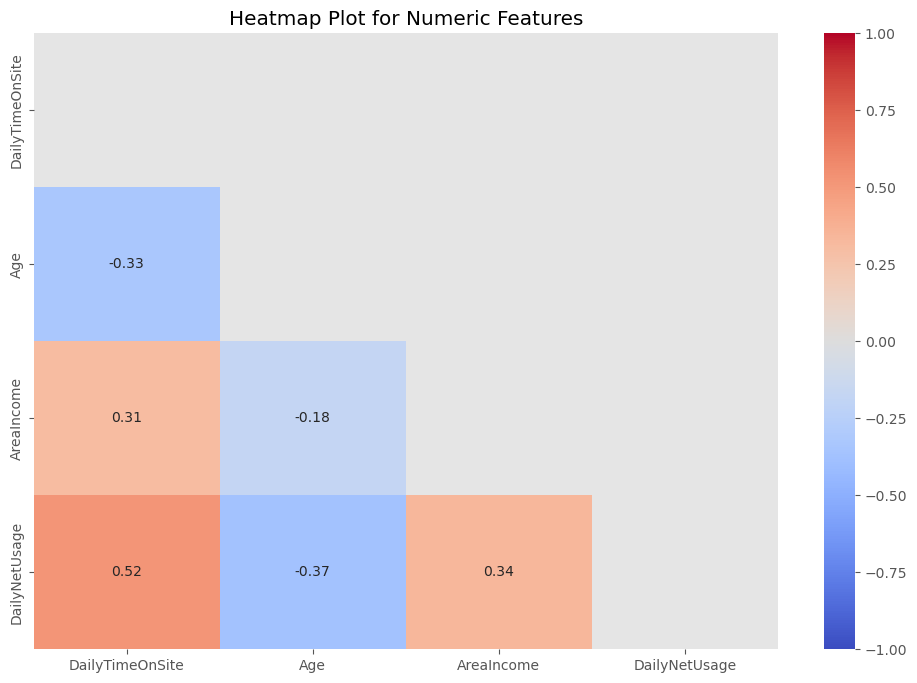

In [15]:
plt.title('Heatmap Plot for Numeric Features')
mask = np.triu(np.ones_like(df.corr(), dtype=bool))
sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap='coolwarm', mask=mask, )
plt.show()

As expected from before, **Age** has negative correlations with the other numerical features. The correlation between **Age** and **AreaIncome** is on the weaker side, meanwhile the strongest correlation is found between **DailyTimeOnSite** and **DailyNetUsage** at 0.52 positive correlation. 

Negative correlations found between **Age** and both time features could be attributed to older demographic being less tech-savvy. Meanwhile, positive correlations found between **AreaIncome** and both time features could be attributed to higher area income might mean a better internet infrastructure that encourage more usage.

The strong correlation between **DailyNetUsage** and **DailyTimeOnSite** is pretty self-explanatory since **DailyTimeOnSite** can be seen as a subset of time spent on the internet. That being said, despite having less than 0.8 correlation, one can argue that both features can be seen as redundant due to the nature of **DailyTimeOnSite** being a part of **DailyNetUsage**.

## Data Cleaning & Preprocessing
Before going into machine learning modeling, I will be doing some cleaning and preprocessing in this step.

### Data Cleaning

Let's start by finding duplicated rows first

In [16]:
dupes = df.duplicated().sum()
print(f'There is {dupes} duplicates found')

There is 0 duplicates found


As previously mentioned, there are some columns with missing values found. However, since previously we have seen that the target columns **AdClick** already has even value distribution, I will avoid deleting rows to preserve this target distribution whenever possible. That being said, let's take another look at the columns.

In [17]:
df.isna().sum().sort_values(ascending=False).head()

DailyTimeOnSite    13
AreaIncome         13
DailyNetUsage      11
Male                3
Age                 0
dtype: int64

Based on EDA done before, here are the method I will be using to fill the missing values:
- **AreaIncome** will be filled with median due to some slight skewness in the distribution
- **Male** will be filled with modus
- **DailyTimeOnSite** and **DailyNetUsage** will be filled with median based on whether they click on ad or not, since they showed a bimodal distribution

In [18]:
df.AreaIncome.fillna(df.AreaIncome.median(), inplace=True)
df.Male.fillna(df.Male.mode()[0], inplace=True)

# Filling missing values based on AdClick
usage_col = ['DailyTimeOnSite', 'DailyNetUsage']
for col in usage_col:
    df[col] = np.where(df[col].notna(), df[col], # return old value if not na
                       np.where(df['AdClick'] == 'Yes',
                                df[df['AdClick'] == 'Yes'][col].median(),
                                df[df['AdClick'] == 'No'][col].median()))

Let's also change **Timestamp** into datetime datatype.

In [19]:
df.Timestamp = pd.to_datetime(df.Timestamp, format='%m/%d/%Y %H:%M')

Now we can extract time data from **Timestamp**. For this project, datetime features extracted will be month, week, and day. Year is not extracted because future prediction will never have same year as training set.

In [20]:
df['month'] = df['Timestamp'].dt.month
df['week'] = df['Timestamp'].dt.isocalendar().week
df['day'] = df['Timestamp'].dt.day
df.drop('Timestamp', axis=1, inplace=True)
df['week'] = df['week'].astype('int64')

Let's do another check for missing values and duplicates after filling the missing values

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   DailyTimeOnSite  1000 non-null   float64
 1   Age              1000 non-null   int64  
 2   AreaIncome       1000 non-null   float64
 3   DailyNetUsage    1000 non-null   float64
 4   Male             1000 non-null   object 
 5   AdClick          1000 non-null   object 
 6   city             1000 non-null   object 
 7   province         1000 non-null   object 
 8   category         1000 non-null   object 
 9   month            1000 non-null   int64  
 10  week             1000 non-null   int64  
 11  day              1000 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 133.9+ KB


In [22]:
dupes = df.duplicated().sum()
print(f'There is {dupes} duplicates found')

There is 0 duplicates found


As can be seen above, the data has been cleaned from missing and duplicated values

Before splitting the data, let's do some encoding as part of cleaning towards **Male** and **AdClick**.

In [23]:
# Encode Male column
map_gender = {'Laki-Laki': 1,
              'Perempuan': 0}
df.Male = df.Male.map(map_gender)
print(f'Encoding result for Male column: {map_gender}')

# Encode AdClick
le = LabelEncoder()
df.AdClick = le.fit_transform(df.AdClick)
map_adclick = dict(zip(le.classes_, le.transform(le.classes_)))
print(f'Encoding result for AdClick column: {map_adclick}')

Encoding result for Male column: {'Laki-Laki': 1, 'Perempuan': 0}
Encoding result for AdClick column: {'No': 0, 'Yes': 1}


### Data Splitting
Before going further into preprocessing, I will do the data splitting to reduce the probability of data leakage. Let's start with splitting the target from the feature.

In [24]:
y = df['AdClick']
x = df.drop('AdClick', axis=1)

In [25]:
x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   DailyTimeOnSite  1000 non-null   float64
 1   Age              1000 non-null   int64  
 2   AreaIncome       1000 non-null   float64
 3   DailyNetUsage    1000 non-null   float64
 4   Male             1000 non-null   int64  
 5   city             1000 non-null   object 
 6   province         1000 non-null   object 
 7   category         1000 non-null   object 
 8   month            1000 non-null   int64  
 9   week             1000 non-null   int64  
 10  day              1000 non-null   int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 126.0+ KB


In [26]:
# Initialize random state
random_state = 47

# Train-test split
x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    random_state=random_state,
                                                    # shuffle=False,
                                                    test_size=0.2,
                                                    stratify=y)

In [27]:
print(f'Total rows in y_train: {y_train.shape[0]}')
print(f'Total rows in y_test: {y_test.shape[0]}')
print(f'Dimension of x_train: {x_train.shape}')
print(f'Dimension of x_test: {x_test.shape}')

Total rows in y_train: 800
Total rows in y_test: 200
Dimension of x_train: (800, 11)
Dimension of x_test: (200, 11)


In [28]:
x_train.head()

,DailyTimeOnSite,Age,AreaIncome,DailyNetUsage,Male,city,province,category,month,week,day
169,86.69,34,435670060.0,198.56,0,Jakarta Timur,Daerah Khusus Ibukota Jakarta,Bank,5,21,27
356,37.45,47,218967070.0,167.86,0,Palembang,Sumatra Selatan,Electronic,4,14,10
332,56.30,49,472016720.0,135.24,1,Banjarmasin,Kalimantan Selatan,Travel,2,5,3
469,65.65,25,447158040.0,224.92,1,Surabaya,Jawa Timur,Electronic,6,22,3
946,72.82,34,530388740.0,191.82,1,Jakarta Pusat,Daerah Khusus Ibukota Jakarta,Food,1,4,27


In [29]:
x_test.head()

,DailyTimeOnSite,Age,AreaIncome,DailyNetUsage,Male,city,province,category,month,week,day
78,56.14,38,228823280.0,113.53,1,Jakarta Barat,Daerah Khusus Ibukota Jakarta,Food,2,5,3
876,67.39,44,358800820.0,107.19,0,Tangerang,Banten,Fashion,1,3,24
496,81.10,29,428204490.0,216.49,1,Bekasi,Jawa Barat,Furniture,7,27,8
479,39.76,28,247453850.0,196.83,1,Bekasi,Jawa Barat,Health,2,6,8
589,39.86,28,358198610.0,161.24,0,Bekasi,Jawa Barat,Otomotif,2,8,23


### Feature Encoding
After the data is split into train and test, it's time to do more preprocessing. While tree based algorithm allows categorical features to be processed, I will still do features encoding to accomodate algorithm like logistic regression. This will open  more options in term of what model can be used to experiment with.

The amount of unique values in these columns are quite big. Since **province** already represent **city** for positional demographic, I opted to drop **city** before using One-Hot Encoding.

In [30]:
ohe = OneHotEncoder(use_cat_names=True)
enc_col = ['province', 'category']

x_train.drop('city', axis=1, inplace=True)
x_test.drop('city', axis=1, inplace=True)

for col in enc_col:
    # Fit and transform on train data
    encoded_train = ohe.fit_transform(x_train[col])
    x_train = pd.concat([x_train, encoded_train], axis=1)

    # Transform on test data according to what's done on train data
    encoded_test = ohe.transform(x_test[col])
    x_test = pd.concat([x_test, encoded_test], axis=1)

    # Drop encoded columns
    x_train.drop(col, axis=1, inplace=True)
    x_test.drop(col, axis=1, inplace=True)

In [31]:
x_train.head()

,DailyTimeOnSite,Age,AreaIncome,DailyNetUsage,Male,month,week,day,province_Daerah Khusus Ibukota Jakarta,province_Sumatra Selatan,province_Kalimantan Selatan,province_Jawa Timur,province_Sumatra Utara,province_Kepulauan Riau,province_Kalimantan Timur,province_Jawa Tengah,province_Bali,province_Jawa Barat,province_Riau,province_Lampung,province_Sulawesi Selatan,province_Banten,province_Kalimantan Barat,province_Sumatra Barat,category_Bank,category_Electronic,category_Travel,category_Food,category_Furniture,category_Otomotif,category_Fashion,category_House,category_Finance,category_Health
169,86.69,34,435670060.0,198.56,0,5,21,27,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
356,37.45,47,218967070.0,167.86,0,4,14,10,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
332,56.30,49,472016720.0,135.24,1,2,5,3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
469,65.65,25,447158040.0,224.92,1,6,22,3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
946,72.82,34,530388740.0,191.82,1,1,4,27,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


## Machine Learning Modeling

For machine learning modeling, normally feature scaling should be done before modeling. However, I was tasked to explicitly train the model twice to observe the effects of feature scaling on several machine learning models.

### Evaluation Functions

In [32]:
# Function to run multiple model simultaneously
def run_models(models):
    '''Takes a list of models, returns prediction result and feature importances when applicable'''
    outputs = []

    for model in models:
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        model_name = str(model).split('(')[0]
        output = {'Model' : model,
                  'Model Name': model_name,
                  'Prediction' : y_pred}
        
        output['Confusion Matrix'] = confusion_matrix(y_test, y_pred)
        
        try:
            # Logreg use different attribute to call for feature importance
            if model == logreg:
                feat_ipt = model.coef_[0]
            else:
                feat_ipt = model.feature_importances_
        # Handling corner case where a model doesn't use feature importance like logreg
        except AttributeError:
            feat_ipt = 0
            print(f'{model} doesn\'t support feature importances')
            
        output['Feature Importances'] = feat_ipt

        outputs.append(output)

    return outputs

def display_evaluations(results, y_test=y_test, show_base_model=False, sort=None):
    '''Takes in results from run_models function.
    
    show_base_model: default = False
    To show parameter tuning if needed
    
    sort: default = None
    takes string to sort dataframe based on certain metrics. Options are 
    'Accuracy', 'Precision', 'Recall', and 'F1-score'.'''
    evals = []
    for result in results:        
        eval = {'Model': result['Model'],
                'Model Name': result['Model Name']}
        y_pred = result['Prediction']
        
        eval['Accuracy'] = accuracy_score(y_test, y_pred)
        eval['Precision'] = precision_score(y_test, y_pred, zero_division=0)
        eval['Recall'] = recall_score(y_test, y_pred, zero_division=0)
        eval['F1-score'] = f1_score(y_test, y_pred, zero_division=0)

        evals.append(eval)

    df_eval = pd.DataFrame(evals)

    if not show_base_model:
        df_eval.drop('Model', axis=1, inplace=True)

    if sort in ['Accuracy', 'Precision', 'Recall', 'F1-score']:
        df_eval.sort_values(by=sort, inplace=True, ascending=False)

    display(df_eval)

### Models and Metrics

For this project, the classification models as can be seen below:
1. Logistic Regression
2. Decision Tree
3. Random Forest
4. AdaBoost
5. XGBoost

Before going into what metrics to use, the business impact of each confusion matrix elements will be as follow:
- True Positive (TP): customers that will click on ads are predicted correctly, resulting in **more clicks**
- True Nevative (TP): customers that will NOT click on ads are predicted correctly, resulting in **more efficient budgeting** by avoiding these customers
- False Positive (FP): customers that will NOT click are predicted to click, resulting in **higher price** due to less efficient targeting
- False Negative (FN): customers that will click are predicted to NOT click, resultin in **opportunity loss** from possible prospect clicks

For this project, the evaluation metrics focus will be **Accuracy**. Accuracy will be the focus metrics under the assumption that the costs between FP and FN are not significant, thus putting equal importance in classifying both customers who will and will not click.

In [33]:
logreg = LogisticRegression(random_state=random_state)
dt = DecisionTreeClassifier(random_state=random_state)
rf = RandomForestClassifier(random_state=random_state)
ada = AdaBoostClassifier(random_state=random_state)
xg = XGBClassifier(random_state=random_state)

models = [logreg, dt, rf, ada, xg]

### Models Before Scaling

Using the run_models function prepared before, the result will be stored in a variable. Display_evaluations function is called using the result from run_models. The resulting display will also be sorted by Accuracy as the focus metrics.

In [34]:
before_scaling = run_models(models)
display_evaluations(before_scaling, sort='Accuracy')

,Model Name,Accuracy,Precision,Recall,F1-score
2,RandomForestClassifier,0.955,0.969072,0.94,0.954315
3,AdaBoostClassifier,0.950,0.989130,0.91,0.947917
1,DecisionTreeClassifier,0.940,0.958333,0.92,0.938776
4,XGBClassifier,0.940,0.958333,0.92,0.938776
0,LogisticRegression,0.500,0.000000,0.00,0.000000


### Feature Transformation - Scaling

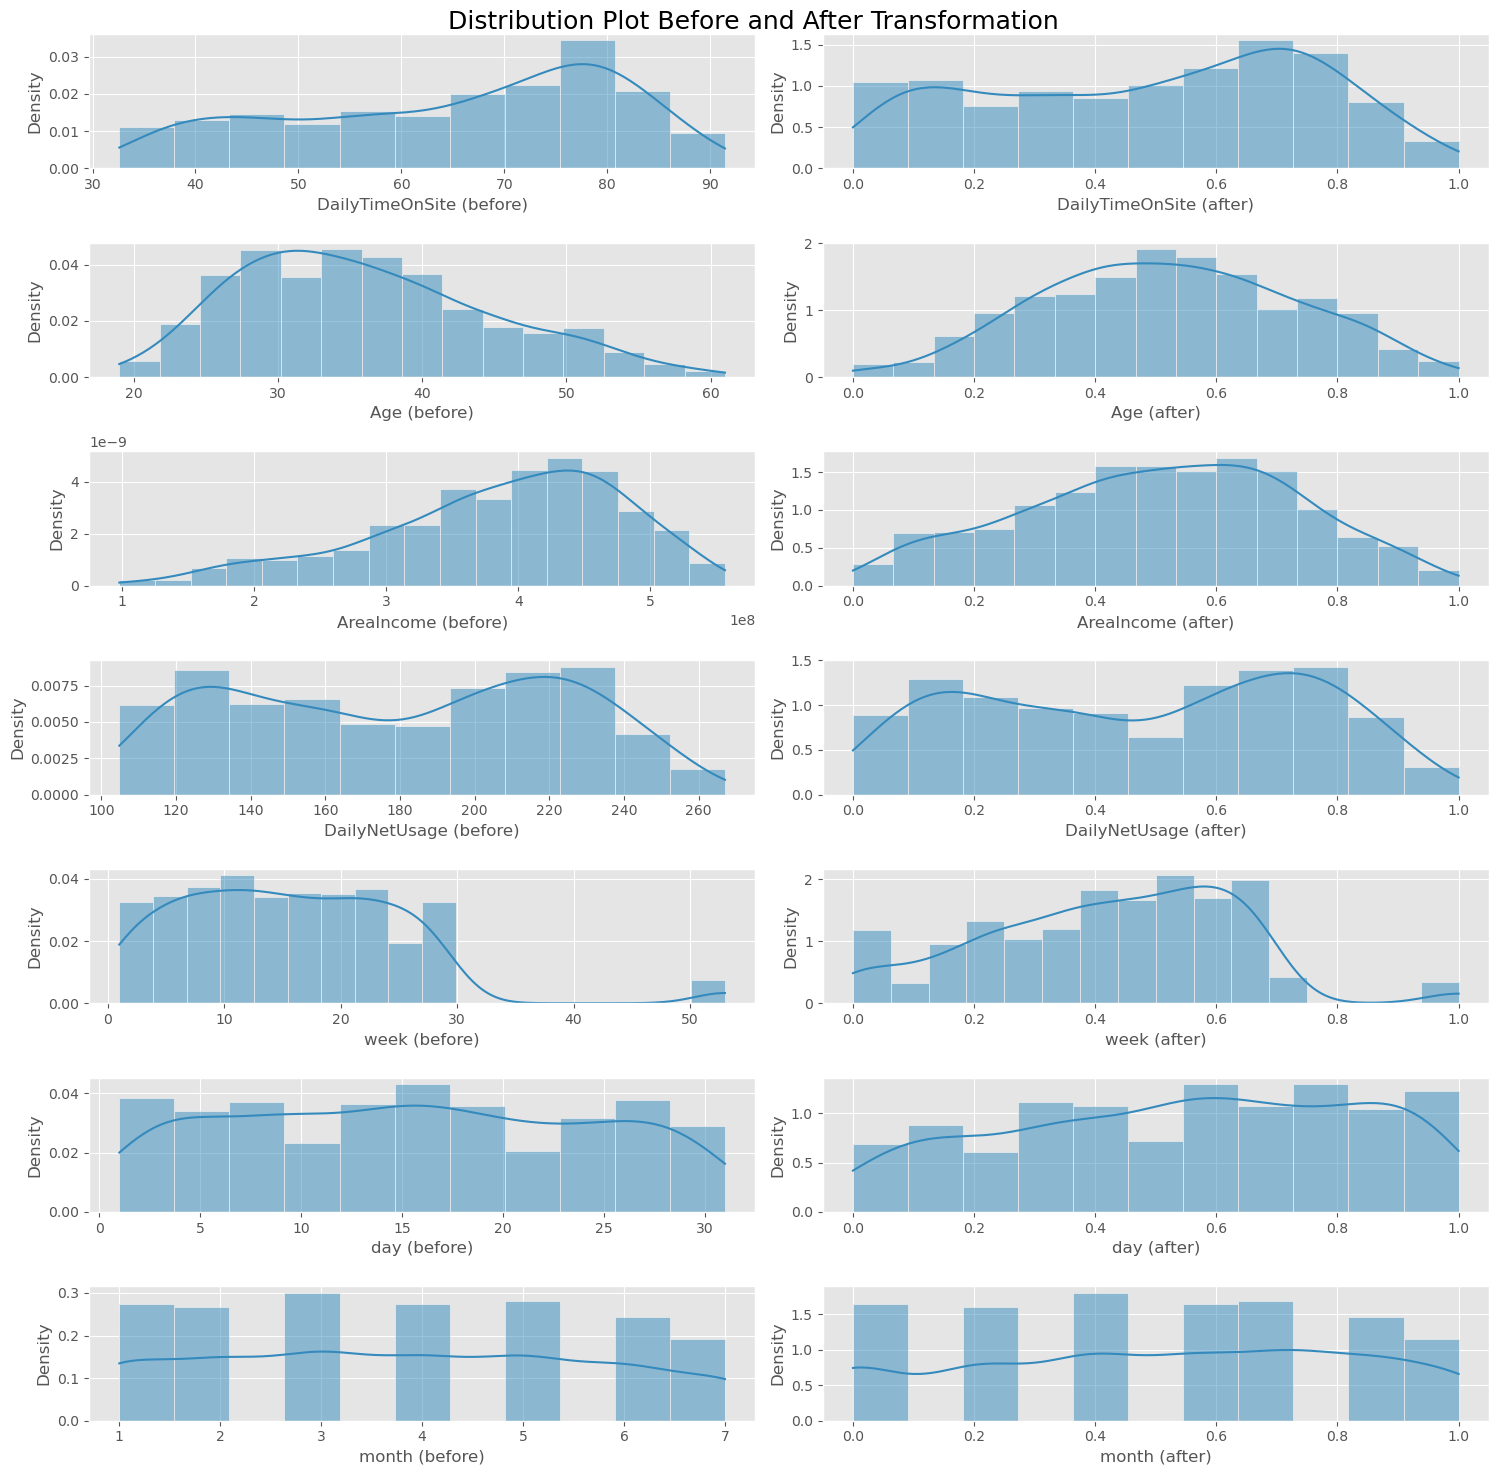

In [35]:
scale_feats = ['DailyTimeOnSite', 'Age', 'AreaIncome', 'DailyNetUsage', 'week', 'day', 'month']
pt = PowerTransformer(method='yeo-johnson')
scaler = MinMaxScaler()

plt.figure(figsize=(15,15))
plt.suptitle('Distribution Plot Before and After Transformation')
for i, col in enumerate(scale_feats):
    plt.subplot(len(scale_feats), 2, 2*i+1)
    sns.histplot(x=x_train[col], kde=True, stat='density')
    plt.xlabel(col + ' (before)')

    # Yeo-Johnson to make distributions more gaussian
    x_train[col] = pt.fit_transform(x_train[[col]])
    x_test[col] = pt.transform(x_test[[col]])

    # Normalize distribution with minmaxscaler
    x_train[col] = scaler.fit_transform(x_train[[col]])
    x_test[col] = scaler.transform(x_test[[col]])

    plt.subplot(len(scale_feats), 2, 2*i+2)
    sns.histplot(x=x_train[col], kde=True, stat='density')
    plt.xlabel(col + ' (after)')
plt.tight_layout()
plt.show()

### Models After Scaling

In [36]:
after_scaling = run_models(models)
display_evaluations(after_scaling, sort='Accuracy')

,Model Name,Accuracy,Precision,Recall,F1-score
0,LogisticRegression,0.955,0.989247,0.92,0.953368
2,RandomForestClassifier,0.950,0.959184,0.94,0.949495
3,AdaBoostClassifier,0.950,0.989130,0.91,0.947917
1,DecisionTreeClassifier,0.940,0.958333,0.92,0.938776
4,XGBClassifier,0.940,0.958333,0.92,0.938776


### Model Comparison Before vs After Scaling

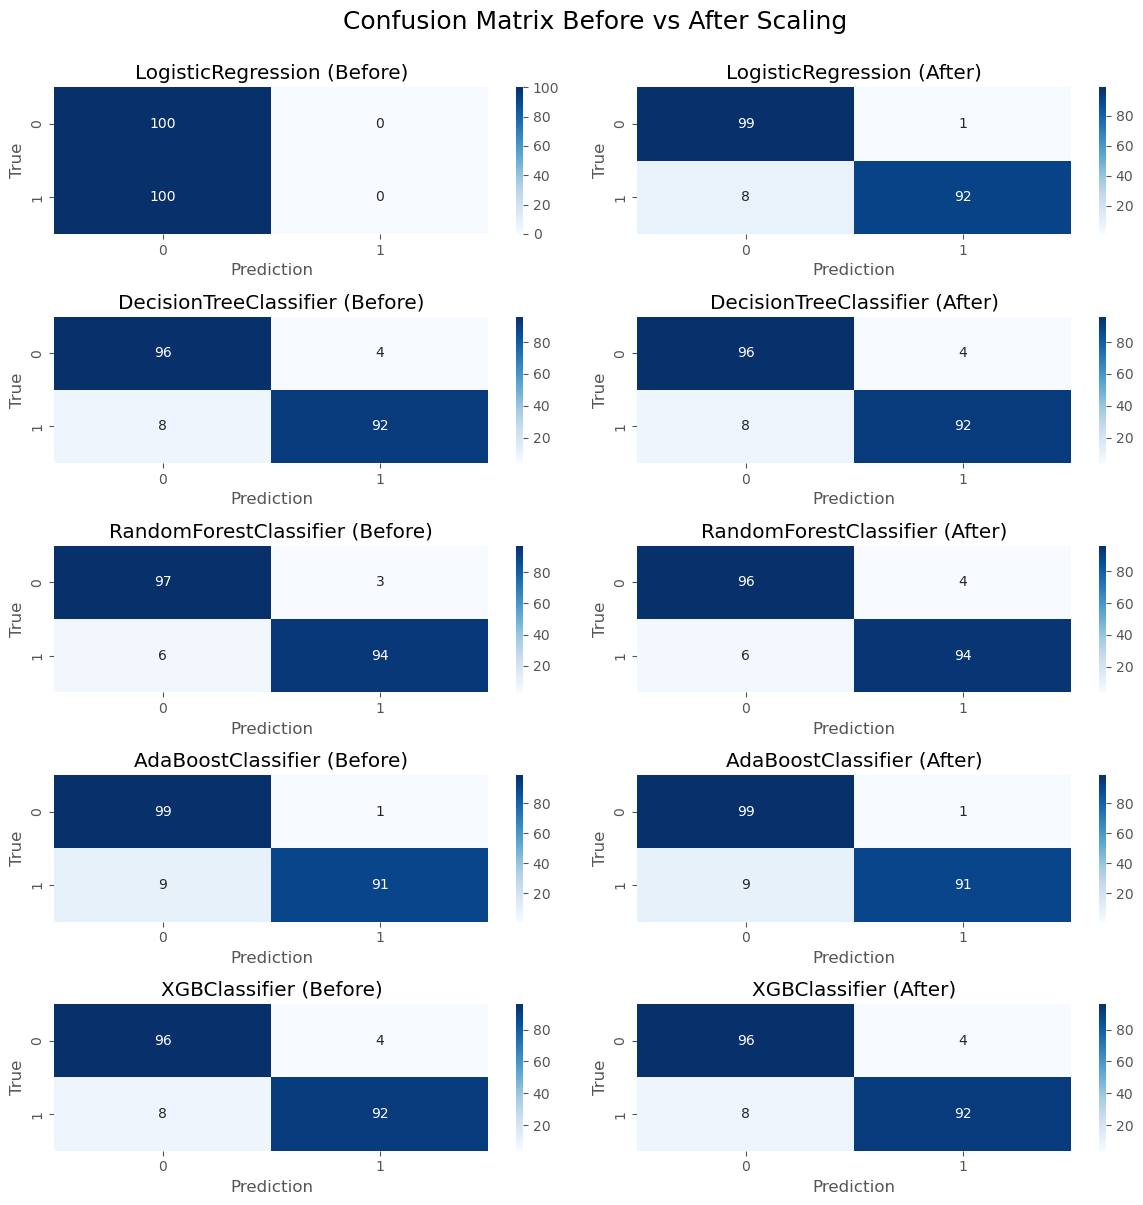

In [37]:
plt.figure(figsize=(12,12))
plt.suptitle('Confusion Matrix Before vs After Scaling', y=1)

for i, model in enumerate(before_scaling):
    plt.subplot(len(models), 2, 2*i+1)
    plt.title(model['Model Name'] + ' (Before)')
    cfm = model['Confusion Matrix']
    sns.heatmap(cfm, annot=True, fmt='g', cmap='Blues')
    plt.xlabel('Prediction')
    plt.ylabel('True')
    
for i, model in enumerate(after_scaling):
    plt.subplot(len(models), 2, 2*i+2)
    plt.title(model['Model Name'] + ' (After)')
    cfm = model['Confusion Matrix']
    sns.heatmap(cfm, annot=True, fmt='g', cmap='Blues')
    plt.xlabel('Prediction')
    plt.ylabel('True')

plt.tight_layout()

As can be seen above, significant changes can be seen on Logistic Regression model. Without tuning its classification threshold, the model simply predicted every customers to not click. After scaling however, Logistic Regression model's performance improved significantly into best accuracy model for this problem.

By explicitly training model without scaling beforehand, it can be concluded that tree based models don't get affected with features' scale. There is a small change observed for Random Forest model's performance, however this change is somewhat insignificant for this specific problem.

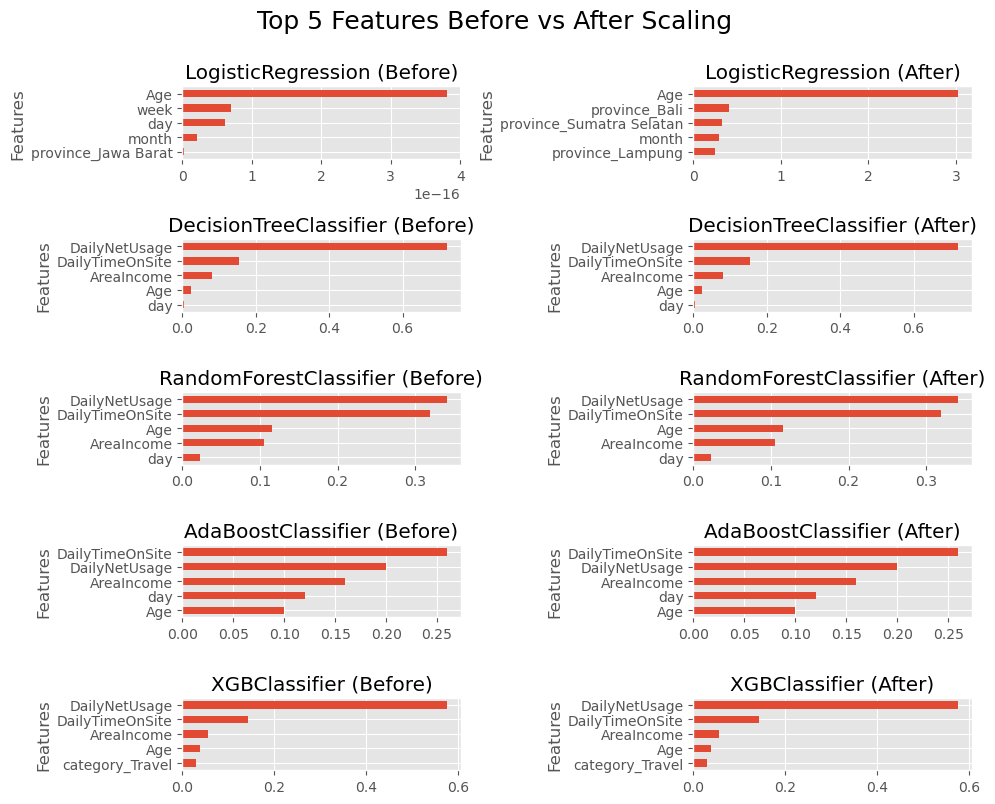

In [38]:
plt.figure(figsize=(15,15))
plt.suptitle('Top 5 Features Before vs After Scaling', y=1)

for i, model in enumerate(before_scaling):
    plt.subplot(len(models), 2, 2*i+1)
    plt.title(model['Model Name'] + ' (Before)')
    feat_importances = pd.Series(model['Feature Importances'], index=x_train.columns)
    ax = feat_importances.nlargest(5).plot(kind='barh', figsize=(10, 8))
    ax.invert_yaxis()
    plt.ylabel('Features')

for i, model in enumerate(after_scaling):
    plt.subplot(len(models), 2, 2*i+2)
    plt.title(model['Model Name'] + ' (After)')
    feat_importances = pd.Series(model['Feature Importances'], index=x_train.columns)
    ax = feat_importances.nlargest(5).plot(kind='barh', figsize=(10, 8))
    ax.invert_yaxis()
    plt.ylabel('Features')

plt.tight_layout()

As concluded before, tree based models aren't affected by feature scaling as there is no shift in top feature importances on them. Let's focus on the changes observed on Logistic Regression.

Unsurprisingly, for LogReg's feature importance before scaling, top features are dominated by features with higher numerical values like **Age**, **week**, and **day**. After scaling, only **Age** remains at the top while some features regarding province started showing up.

### Model Selection & Business Insight

Considering performance after scaling, Logistic Regression will be selected as the model for this problem.

In [39]:
selected = after_scaling[0]
selected['Model Name']

'LogisticRegression'

Text(0, 0.5, 'Features')

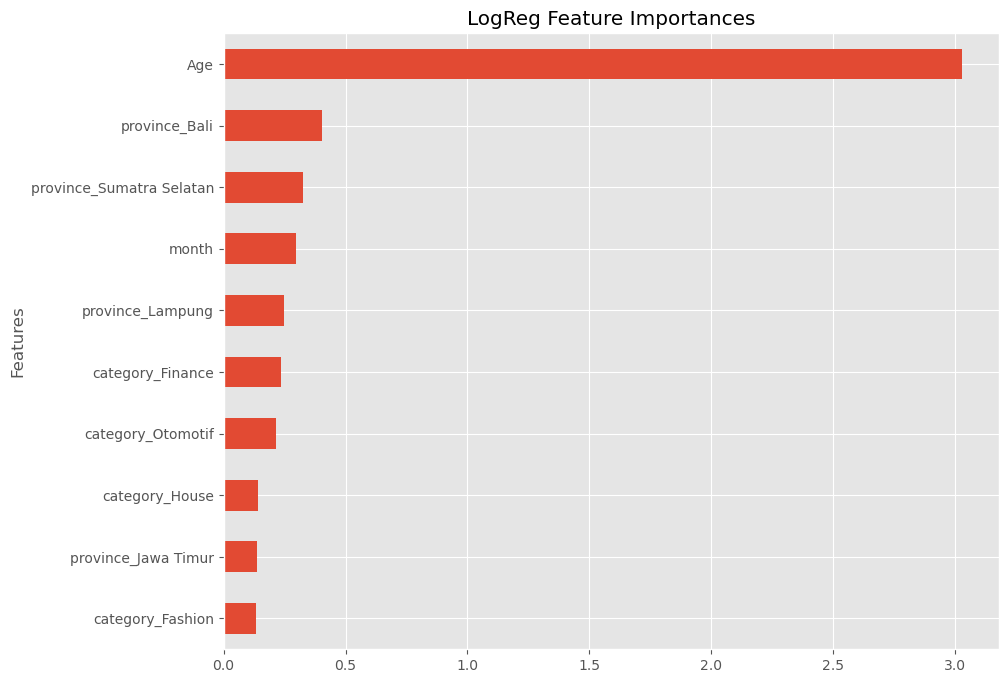

In [40]:
plt.title('LogReg Feature Importances')
feat_importances = pd.Series(selected['Feature Importances'], index=x_train.columns)
ax = feat_importances.nlargest(10).plot(kind='barh', figsize=(10, 8))
ax.invert_yaxis()
plt.ylabel('Features')

Based on the graph above, some takeaways will be:
- Age is by far the most important feature in determining whether someone click on ads or not
- Customers from Bali and Sumatera Selatan are more likely to click
- The month when ads run increases the likelihood for customers to click

## Business Recommendations

Using takeaways from the insights taken from feature importance, another EDA will be done to gather more insights.

### Age

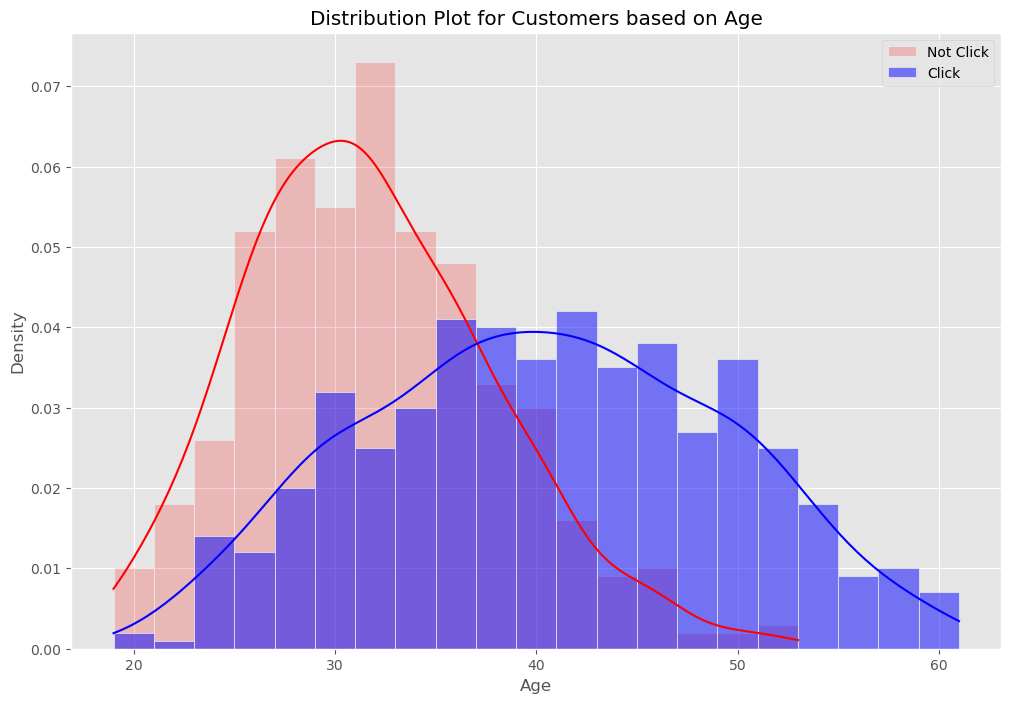

In [41]:
plt.title('Distribution Plot for Customers based on Age')
sns.histplot(data=df[df.AdClick == 0], x='Age', stat='density', 
             kde=True, binwidth=2, color='r', alpha=.2, label='Not Click')
sns.histplot(data=df[df.AdClick == 1], x='Age', stat='density', 
             kde=True, binwidth=2, color='b', alpha=.5, label='Click')
plt.legend()
plt.show()

Based on that graph, there are more customers who click on ads compared to not clicking starting from age 36. Older customers appears to be moer likely to click on ads, with age range of 42-60 having a good ads click rate.

Based on that insight, future ads should be **personalized towards customers between age 40 and 60**.

### Province

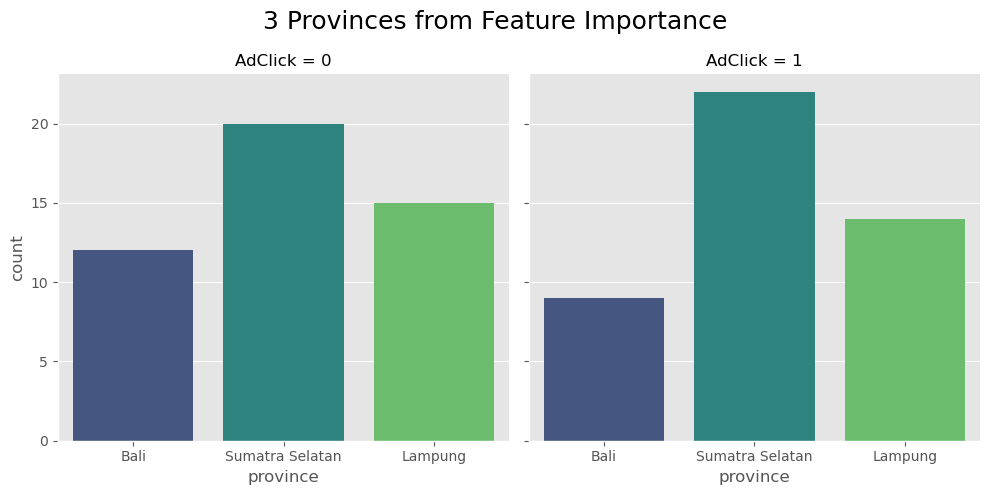

In [42]:
ft_imp_provinces = ['Bali', 'Sumatra Selatan', 'Lampung']

g = sns.FacetGrid(df[df['province'].isin(ft_imp_provinces)], col='AdClick', height=5)
plt.suptitle('3 Provinces from Feature Importance')
g.map(sns.countplot, 'province', order=ft_imp_provinces, palette='viridis')
plt.show()

Despite having higher feature importance according to Logistic Regression, there isn't much significant impact of these 3 provinces towards ad clicks. However, based on observation customers from Bali and Lampung tends to not click on ads, while custoemrs from Sumatra Selatan is more likely to click on ads.

Due to the lack of impact towards ad click, there is no business recommendation to be made. It might be a good idea to investigate further elsewhere.

### Month

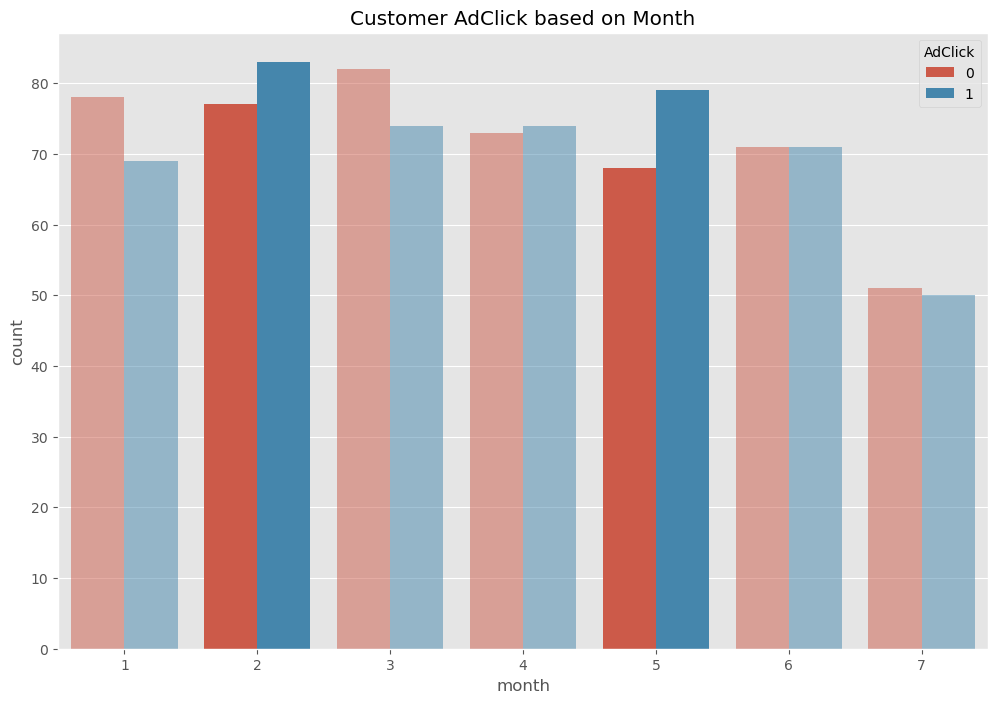

In [56]:
plt.title('Customer AdClick based on Month')

ax = sns.countplot(data=df, x='month', hue='AdClick')
for i, bar in enumerate(ax.patches):
    if i in [0, 2, 3, 5, 6, 7, 9, 10, 12, 13]:
        bar.set_alpha(.5)

plt.show()

Based on graph above, ads click rate for each monts are very close to 50% just like our whole sample. That being said, February and May showed better ads click rate compared to other months. This might be attributed to these 2 months being more leisure with holidays and/or special occassions.

Based on that, it is recommended to **run special campaign on February or May**.